<a href="https://colab.research.google.com/github/saif-mahmud/hierarchical-attention-HAR/blob/master/usc_had_HSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Download and Preprocessing

#### Raw Data Download

In [0]:
!wget http://sipi.usc.edu/had/USC-HAD.zip
!unzip -q USC-HAD.zip

--2020-06-02 15:37:46--  http://sipi.usc.edu/had/USC-HAD.zip
Resolving sipi.usc.edu (sipi.usc.edu)... 128.125.20.90
Connecting to sipi.usc.edu (sipi.usc.edu)|128.125.20.90|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44583390 (43M) [application/zip]
Saving to: ‘USC-HAD.zip’

USC-HAD.zip         100%[===================>]  42.52M  71.8MB/s    in 0.6s    

2020-06-02 15:37:47 (71.8 MB/s) - ‘USC-HAD.zip’ saved [44583390/44583390]



#### Library Import

In [0]:
%tensorflow_version 2.x
%load_ext tensorboard

import os

import tensorflow as tf
import numpy as np
import scipy.io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Data Preprocessing

In [0]:
DIR = './USC-HAD/'

subject = []
act_num = []
sensor_readings = []

def read_dir(directory):
    for path, subdirs, files in os.walk(DIR):
        for name in files:
            if name.endswith('.mat'):
                mat = scipy.io.loadmat(os.path.join(path, name))
                subject.extend(mat['subject'])
                sensor_readings.append(mat['sensor_readings'])

                if mat.get('activity_number') is None:
                    act_num.append('11')
                else:
                    act_num.append(mat['activity_number'])
    return subject, act_num, sensor_readings

subject, act_num, sensor_readings = read_dir(DIR)

In [0]:
# get acc + gyr sensor readings and put in df (dataframe)
acc_x = []
acc_y = []
acc_z = []
gyr_x = []
gyr_y = []
gyr_z = []

act_label = []
subject_id = []
df = None

for i in range(840):
    for j in sensor_readings[i]:   
        acc_x.append(j[0]) # acc_x
        acc_y.append(j[1]) # acc_y
        acc_z.append(j[2]) # acc_z
        gyr_x.append(j[3]) # gyr_x
        gyr_y.append(j[4]) # gyr_y
        gyr_z.append(j[5]) # gyr_z
        act_label.append(act_num[i])
        subject_id.append(subject[i])
        
df = pd.DataFrame({'subject':subject_id,'acc_x':acc_x,'acc_y':acc_y,'acc_z':acc_z,'gyr_x':gyr_x,'gyr_y':gyr_y,'gyr_z':gyr_z,'activity':act_label})                   

df = df[['subject','acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z','activity']]

df['activity']=df['activity'].astype(int)

# save csv file
df.to_csv('usc-had_raw.csv', index=False)

# print size of dataset
print('Dataset Size :', len(df))

Dataset Size : 2811490


In [0]:
activity_map = { 1:'Walking Forward', 2:'Walking Left',  3:'Walking Right',
                4:'Walking Upstairs', 5:'Walking Downstairs', 6:'Running Forward',
                7:'Jumping Up', 8:'Sitting', 9:'Standing', 10: 'Sleeping',
                11:'Elevator Up', 12:'Elevator Down'}
activity_list = list(activity_map.values())

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811490 entries, 0 to 2811489
Data columns (total 8 columns):
 #   Column    Dtype  
---  ------    -----  
 0   subject   object 
 1   acc_x     float64
 2   acc_y     float64
 3   acc_z     float64
 4   gyr_x     float64
 5   gyr_y     float64
 6   gyr_z     float64
 7   activity  int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 171.6+ MB


#### Data Visualization

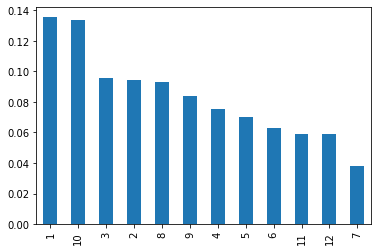

In [0]:
df['activity'].value_counts(normalize=True).plot(kind='bar')

#### Train-Test Split

In [0]:
saved_df = pd.read_csv('usc-had_raw.csv')
saved_df.columns

Index(['subject', 'acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z',
       'activity'],
      dtype='object')

In [0]:
train_subject = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
validation_subject = [11, 12]
test_subject = [13, 14]

x_columns = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']
y_columns = 'activity'

In [0]:
def get_exp_data(downsample=False):
    train_df = saved_df.loc[saved_df['subject'].isin(train_subject)]
    validation_df = saved_df.loc[saved_df['subject'].isin(validation_subject)]
    test_df = saved_df.loc[saved_df['subject'].isin(test_subject)]
    
    if downsample:
        train_df = train_df[::3,:]
        validation_df = validation_dfn[::3,:]
        test_df = test_df[::3,:]

    return train_df, validation_df, test_df

In [0]:
train_df, val_df, test_df = get_exp_data(downsample=False)

### Window - session

In [0]:
SLIDING_WINDOW_LENGTH = 1000
SLIDING_WINDOW_STEP = 500

In [0]:
def create_windowed_dataset(df, features= x_columns, class_label = y_columns, window_size=32, stride = 16):
    X = df[features].values
    y = df[class_label].values
    segments = []
    labels = []

    seg_start= 0
    seg_end = window_size
    while seg_end <= len(X):
        if len(np.unique(y[seg_start:seg_end])) == 1: #valid-window
            segments.append(X[seg_start:seg_end])
            labels.append(y[seg_start]) # doesn't matter all same labels

            seg_start += stride
            seg_end = seg_start + window_size

        else: #mixed- discard last few samples, move start to the new activity
            current_label = y[seg_start]
            for i in range(seg_start, seg_end):
                if y[i] != current_label:
                    seg_start = i
                    seg_end = seg_start + window_size
                    break

    return np.asarray(segments).astype(np.float32), np.asarray(labels)

In [0]:
X_train, y_train = create_windowed_dataset(train_df, window_size=SLIDING_WINDOW_LENGTH, stride = SLIDING_WINDOW_STEP)
X_val, y_val = create_windowed_dataset(val_df, window_size=SLIDING_WINDOW_LENGTH, stride = SLIDING_WINDOW_STEP)
X_test, y_test = create_windowed_dataset(test_df, window_size=SLIDING_WINDOW_LENGTH, stride = SLIDING_WINDOW_STEP)

NameError: ignored

In [0]:
pd.Series(y_train).value_counts()

NameError: ignored

In [0]:
# count = 1
# prev = y_train[0]
# for wndw in y_train:
#     if wndw == prev:
#         count+=1
#     else:
#         print(f'{activity_map[prev]} -  {count} windows')
#         count=1
#     prev=wndw

In [0]:
N_WINDOW= 20
N_TIMESTEP = 50

In [0]:
X_train = X_train.reshape((X_train.shape[0], N_WINDOW, N_TIMESTEP, 6))
X_val = X_val.reshape((X_val.shape[0], N_WINDOW, N_TIMESTEP, 6))
X_test = X_test.reshape((X_test.shape[0], N_WINDOW, N_TIMESTEP, 6))

y_train = tf.keras.utils.to_categorical(y_train-1)
y_val = tf.keras.utils.to_categorical(y_val-1)
y_test = tf.keras.utils.to_categorical(y_test-1)

NameError: ignored

In [0]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

(2882, 20, 50, 6)
(2882, 12)
(918, 20, 50, 6)
(918, 12)
(786, 20, 50, 6)
(786, 12)


## tf data

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [0]:
test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_dataset = test_dataset.batch(32)

In [0]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 512

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(32)

## Model

In [0]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model, include_dropout=True, dropout_rate=0.2):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)
        self.include_dropout = include_dropout
        if include_dropout:
            self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, x):
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[:, :tf.shape(x)[1], :]
        if self.include_dropout:
            x = self.dropout(x)
        return x

In [0]:
class LearnedPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, num_positions, d_model, include_dropout=True, dropout_rate=0.2):
        super(LearnedPositionalEncoding, self).__init__()
        self.d_model = d_model
        self.pos_encoding = tf.keras.layers.Embedding(num_positions, d_model)
        self.include_dropout = include_dropout
        if include_dropout:
            self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

    def call(self, x):
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding(tf.expand_dims(tf.range(tf.shape(x)[1]), axis=0))
        if self.include_dropout:
            x = self.dropout(x)
        return x

In [0]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model,use_bias=False)
        self.wk = tf.keras.layers.Dense(d_model,use_bias=True)
        self.wv = tf.keras.layers.Dense(d_model,use_bias=True)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                        (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
            
        return output, attention_weights


def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


In [0]:
class AggregateAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(AggregateAttention, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.d_model = d_model
        self.query = self.add_weight("learned_query",
                                     shape=[1, 1, self.d_model],
                                     initializer=tf.keras.initializers.Orthogonal())  
    
    def call(self, v, k):
        batched_query = tf.tile(self.query, [tf.shape(v)[0],1,1])
        output, attention_weights = self.mha(v, k, batched_query, mask=None)
        output = tf.squeeze(output, axis=1)
        attention_weights = tf.squeeze(attention_weights, axis=2)
        return output, attention_weights

In [0]:
class AggregateAttentionBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, expand_dim_factor, rate=0.1):
        super(AggregateAttentionBlock, self).__init__()
        self.aga = AggregateAttention(d_model*expand_dim_factor, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model*expand_dim_factor, dff*expand_dim_factor)

        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training):
        attn_output, attn_scores = self.aga(x, x)
        attn_output = self.dropout1(attn_output, training=training)
        
        ffn_output = self.ffn(attn_output)  # (batch_size, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out = self.layernorm(ffn_output + attn_output)  # (batch_size, d_model)
        return out, attn_scores

In [0]:
class SelfAttentionBlock(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(SelfAttentionBlock, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask=None):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2


In [0]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, n_timesteps, d_model, num_heads, dff, num_sa_blocks=1, add_pe=True, pe_type = 'learned', expand_dim_factor=1, dropout_rate=0.1):
        super(EncoderBlock, self).__init__()
        self.add_pe = add_pe
        if self.add_pe:
            if pe_type == 'fixed': 
                self.pe = PositionalEncoding(n_timesteps, d_model, dropout_rate=dropout_rate)
            else:
                self.pe = LearnedPositionalEncoding(n_timesteps, d_model, dropout_rate=dropout_rate)
        self.pe = PositionalEncoding(n_timesteps, d_model)
        self.self_attn_blocks = tf.keras.Sequential(
            [SelfAttentionBlock(d_model, num_heads, dff, dropout_rate) for _ in range(num_sa_blocks)]
            )
        self.attn_aggr = AggregateAttentionBlock(d_model, num_heads, dff, expand_dim_factor, dropout_rate)

    def call(self, x):
        if self.add_pe:
            x = self.pe(x)
        x = self.self_attn_blocks(x)
        x, _  = self.attn_aggr(x)
        return x

    def compute_output_shape(x, input_shape):
        return tf.TensorShape([input_shape[0], input_shape[-1]])

In [0]:
class HSAEncoder(tf.keras.layers.Layer):
    def __init__(self, n_window, n_timesteps, d_model, num_heads, dff, expand_dim_factor, dropout_rate=0.1):
        super(HSAEncoder, self).__init__()
        self.n_window = n_window
        self.d_model = d_model
        self.n_timesteps = n_timesteps
        self.expand_dim_factor = expand_dim_factor
        self.window_encoder = EncoderBlock(n_timesteps, d_model, num_heads,dff,
                                           num_sa_blocks=2, add_pe=True,
                                           pe_type = 'learned',
                                           expand_dim_factor = expand_dim_factor, 
                                           dropout_rate=dropout_rate)
        self.session_encoder = EncoderBlock(n_window, d_model*expand_dim_factor,
                                            num_heads,dff*expand_dim_factor,
                                            num_sa_blocks=2, add_pe=True,
                                            pe_type = 'learned',
                                            expand_dim_factor = expand_dim_factor,
                                            dropout_rate=dropout_rate)
     
        
    def call(self, x):
        batch_size = tf.shape(x)[0]
        x = tf.reshape(x, (-1, self.n_timesteps, self.d_model)) # all sessions in batch dim
        x = self.window_encoder(x)
        x = tf.reshape(x, (batch_size, -1, self.d_model*self.expand_dim_factor))
        x = self.session_encoder(x)
        return x


    def compute_output_shape(x, input_shape):
        return tf.TensorShape([input_shape, self.d_model*self.expand_dim_factor**2])

In [0]:
class MLPClassifier(tf.keras.layers.Layer):
    def __init__(self, num_classes, hidden_layers = [64]):
        super(MLPClassifier, self).__init__()
        self.layers = tf.keras.Sequential(
            [tf.keras.layers.Dense(num_units, activation='relu') for num_units in hidden_layers]
        )
        self.final_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
        self.dropout = tf.keras.layers.Dropout(0.3)

    def call(self, x):
        x = self.layers(x)
        x = self.dropout(x)
        return self.final_layer(x)

In [0]:
class HARModel(tf.keras.Model):
    def __init__(self, num_classes, n_window, n_timesteps, d_model, num_heads, dff,expand_dim_factor=1, dropout_rate=0.3):
        super(HARModel, self).__init__()
        self.data_transform = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(d_model, 1, activation='relu'))
        self.encoder = HSAEncoder(n_window, n_timesteps, d_model, num_heads, dff,expand_dim_factor, dropout_rate)
        self.classifier = MLPClassifier(num_classes)

    def call(self, x):
        x = self.data_transform(x)
        x = self.encoder(x)
        return self.classifier(x)

## Training

In [0]:
model = HARModel(num_classes=12, n_window=N_WINDOW, n_timesteps=N_TIMESTEP,
                 d_model=64, num_heads=4, dff=128, expand_dim_factor=2, dropout_rate=0.1)

In [0]:
tf.keras.backend.clear_session()
model.compile(tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
              metrics=['accuracy'])

In [0]:
model.build((64, N_WINDOW,N_TIMESTEP, 6))
model.summary()

Model: "har_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri multiple                  448       
_________________________________________________________________
hsa_encoder (HSAEncoder)     multiple                  908416    
_________________________________________________________________
mlp_classifier (MLPClassifie multiple                  17228     
Total params: 926,092
Trainable params: 926,092
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset)

Epoch 1/30
46/46 [==============================] - 3s 74ms/step - loss: 1.4127 - accuracy: 0.7609 - val_loss: 2.0046 - val_accuracy: 0.4085
Epoch 2/30
46/46 [==============================] - 3s 74ms/step - loss: 1.4285 - accuracy: 0.7585 - val_loss: 1.7001 - val_accuracy: 0.5948
Epoch 3/30
46/46 [==============================] - 3s 73ms/step - loss: 1.3756 - accuracy: 0.7783 - val_loss: 1.5210 - val_accuracy: 0.6721
Epoch 4/30
46/46 [==============================] - 3s 72ms/step - loss: 1.4371 - accuracy: 0.7495 - val_loss: 1.7763 - val_accuracy: 0.5218
Epoch 5/30
46/46 [==============================] - 3s 74ms/step - loss: 1.6490 - accuracy: 0.6031 - val_loss: 1.6385 - val_accuracy: 0.5708
Epoch 6/30
46/46 [==============================] - 3s 73ms/step - loss: 1.4575 - accuracy: 0.7120 - val_loss: 1.8112 - val_accuracy: 0.4967
Epoch 7/30
46/46 [==============================] - 3s 73ms/step - loss: 1.3940 - accuracy: 0.7516 - val_loss: 1.5424 - val_accuracy: 0.6362
Epoch 8/30
46

In [0]:
pred = model.predict(test_dataset)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred, axis=1)))

              precision    recall  f1-score   support

           0       0.73      0.70      0.71       143
           1       0.97      0.38      0.54        85
           2       0.82      0.86      0.84        71
           3       0.07      0.04      0.05        25
           4       0.14      0.26      0.18        23
           5       0.50      0.74      0.59        69
           6       0.50      0.38      0.43        24
           7       0.24      0.49      0.32        90
           8       0.45      0.65      0.53        60
           9       0.73      0.08      0.14       142
          10       0.36      0.91      0.52        32
          11       0.00      0.00      0.00        22

    accuracy                           0.49       786
   macro avg       0.46      0.46      0.41       786
weighted avg       0.59      0.49      0.46       786



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


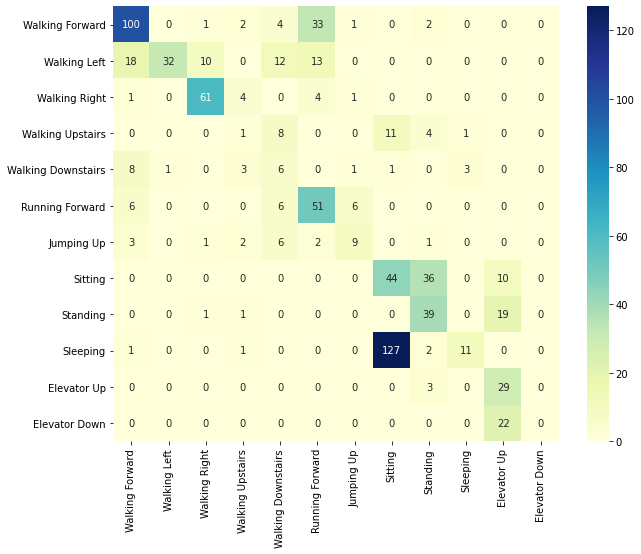

In [0]:
confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))

df_cm = pd.DataFrame(confm, index=activity_list, columns=activity_list)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")

In [0]:
!nvidia-smi

Tue Jun  2 15:40:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    34W / 250W |   4771MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  